# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных
Данные находятся в файле` /datasets/autos.csv`.

## Признаки
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

## Целевой признак
- **Price** — цена (евро)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

import numpy as np
import time

In [2]:
# настройки
pd.set_option('float_format', '{:,.2f}'.format)

# 1. Подготовка данных

In [3]:
# универсальное чтение данных
name = 'autos.csv'

try:
    # local
    data = pd.read_csv("./datasets/" + name,
                       parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    try:
        # https://jupyterhub.praktikum-services.ru/
        data = pd.read_csv("/datasets/" + name,
                           parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
    except:
        # https://praktikum.yandex.ru/
        data = pd.read_csv("https://..." + name,
                           parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
finally:
    original_data = data.copy() 
    print(data.info())
    display(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


## Смотрим пропуски

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
data.VehicleType.value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [6]:
data.Gearbox.value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

In [7]:
data.FuelType.value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [8]:
data.NotRepaired.value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Достаточно просто можно заполнить только `NotRepaired` т.к. по сути это бинарный признак с явным перекосом в данных. Но на данном этапе, что либо с данными делать не будем. ~~Посмотрим далее, как будут работать с пропусками модели градиентного бустинга.~~

## Удаление пропусков
Удаляем так как некоторые модели не обрабатываю пропуски. Но, например, `CatBoost` умеет работать с пропусками~~, поэтому дальше протестируем без удаления пропусков~~

In [9]:
print(data.shape)
data = data.dropna()
print(data.shape)

(354369, 16)
(245814, 16)


Такое решение допустимо, но не желательно, так как удаляетсяочень много данных.

## Удаляем данные не несущие полезной нагрузки

In [10]:
data.nunique()

DateCrawled          203782
Price                  3405
VehicleType               8
RegistrationYear         83
Gearbox                   2
Power                   540
Model                   249
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    39
NotRepaired               2
DateCreated             103
NumberOfPictures          1
PostalCode             8073
LastSeen             132195
dtype: int64

Признак `NumberOfPictures` вообще не содержит значений отличных от нуля - удаляем

In [11]:
data = data.drop(columns='NumberOfPictures')

Точное время также считаю не информативным признаком, достаточно даты

In [12]:
data['DateCrawled'] = data['DateCrawled'].dt.date
data['LastSeen'] = data['LastSeen'].dt.date

## Оценим распределения некоторых количественных признаков

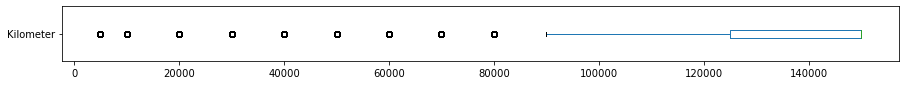

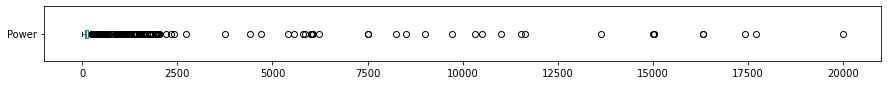

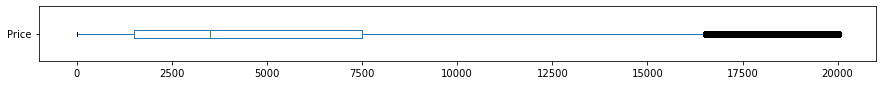

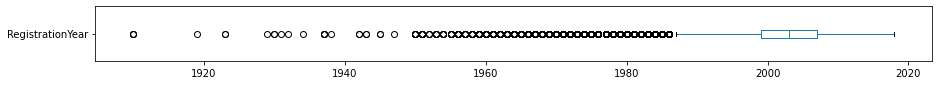

In [13]:
count_columns = ['Kilometer', 'Power', 'Price', 'RegistrationYear']
for col in count_columns:
    data[col].plot(kind='box',figsize=(15,1), vert=False)
    plt.show()

Достаточно странное распределение по мощности посмотрим подробнее на большие значения:

476.0


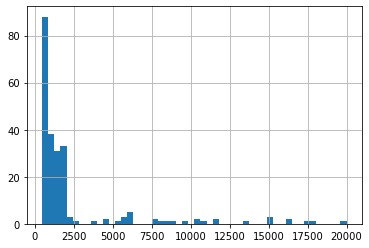

In [14]:
limit = data.Power.quantile(0.999)
print(limit)
data[data.Power > limit].Power.hist(bins=50)
plt.show()

Очевидно, что что-то с этими данными не так. Удалим все записи > 500 л.с.

In [15]:
data = data[data.Power < 500]

In [16]:
data.shape

(245592, 15)

Стало примерно на 500 записей меньше. Проверим распределение

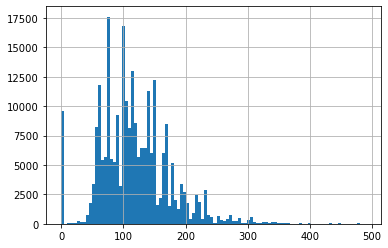

In [17]:
data.Power.hist(bins=100)
plt.show()

Много нулевых значений, что может плохо сказать на качестве моделей. Удалим

In [18]:
data = data[data.Power != 0]

Также очень странное распределение для `RegistrationYear`, оценим сколько значений за пределами разумного

In [19]:
data[(data.RegistrationYear > 2020) | (data.RegistrationYear < 1960)].shape

(63, 15)

Удаляем

In [20]:
data = data[(data.RegistrationYear < 2020) & (data.RegistrationYear > 1960)]


Проверяем по гистограмме

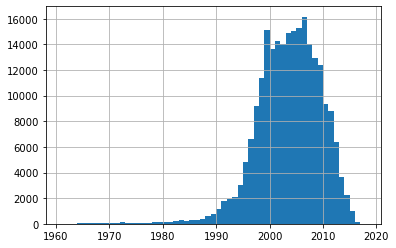

In [21]:
data.RegistrationYear.hist(bins=int(data.RegistrationYear.max() - data.RegistrationYear.min()))
plt.show()

Взглянем также на парные диаграммы

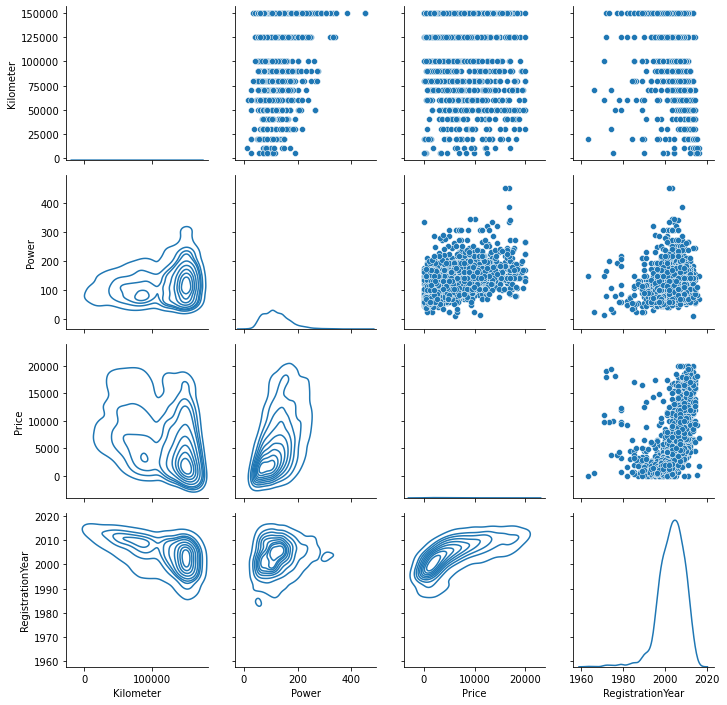

In [22]:
g = sns.PairGrid(data=data[count_columns].dropna().sample(2000)) # берем часть данных, т.к. иначе долго
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)

plt.show()

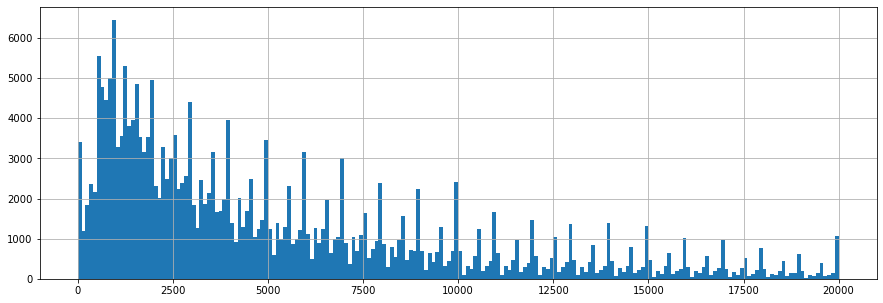

In [23]:
# немного подробнее для Price
data.Price.hist(bins=200, figsize=(15,5))
plt.show()

Можно заметить всплеск нулевых цен, что странно. Удаляем такие

In [24]:
(data.Price == 0).sum()

2911

In [25]:
data = data[data.Price != 0]

## Обработка почтовых индексов
Судя по маркам распространенным маркам автомобилей можно сделать вывод, что этот датасет из Германии, следовательно воспользуемся информацией с википедии:

>Современный PLZ-индекс состоит из пяти цифр.
>
>Первая (крайняя левая) цифра в PLZ-коде обозначает зону (Zone) и, соответственно, аэропорт, через который происходит обмен почтой с этой зоной. При этом следует понимать, что зональное деление PLZ-кодов не соответствует административному делению Германии на земли.
>
>Вторая цифра в PLZ-коде обозначает регион зоны и вместе с номером зоны образует двузначный номер региона, который определяет дальнейшую маршрутизацию почты внутри зоны.

Оставим только первые две цифры почтового кода, так как они привязаны к определённому району страны, что может влиять на ценообразование товаров.

In [26]:
data.PostalCode = data.PostalCode // 1000

## Масштабирование признаков
Выделяем числовые признаки с различным масштабом

In [27]:
count_columns = ['Kilometer', 'Power', 'RegistrationYear']

scaler = StandardScaler()
scaler.fit(data[count_columns])
data[count_columns] = scaler.transform(data[count_columns])

**Примечание**: нормализацию данных стоит проводить после разделения выборки на части. В таком случае scaler чтоит обучить только на тренировочном наборе данных. Это поможет уменьшить переобучение и избавит от ликов.

## Преобразование категориальных переменных
Определим необходимые признаки

In [28]:
data.nunique()

DateCrawled            34
Price                3369
VehicleType             8
RegistrationYear       58
Gearbox                 2
Power                 392
Model                 249
Kilometer              13
RegistrationMonth      13
FuelType                7
Brand                  39
NotRepaired             2
DateCreated           103
PostalCode             95
LastSeen               34
dtype: int64

In [29]:
cat_features = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'NotRepaired',
]

In [30]:
enc = OrdinalEncoder(dtype='int')
enc.fit(data[cat_features])
data[cat_features] = enc.transform(data[cat_features])

In [31]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
3,2016-03-17,1500,5,-0.35,1,-0.90,116,0.62,6,6,37,0,2016-03-17,91,2016-03-17
4,2016-03-31,3600,5,0.81,1,-1.01,101,-1.00,7,2,31,0,2016-03-31,60,2016-04-06
5,2016-04-04,650,4,-1.35,1,-0.39,11,0.62,10,6,2,1,2016-04-04,33,2016-04-06
6,2016-04-01,2200,1,0.15,1,-0.26,8,0.62,8,6,25,0,2016-04-01,67,2016-04-05
10,2016-03-26,2000,4,0.15,1,-0.34,10,0.62,12,6,19,0,2016-03-26,96,2016-04-06


## Разделение данных

In [32]:
features = data.drop(columns=['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'])
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
# features_train, features_valid, target_train, target_valid = train_test_split(
#     features_train, target_train, test_size=0.25, random_state=12345)

# 2. Обучение моделей

Оценим значения целевой метрики, чтобы было проще оценить полученные RMSE

In [33]:
target.describe()

count   232,984.00
mean      5,288.12
std       4,725.98
min           1.00
25%       1,555.00
50%       3,666.00
75%       7,750.00
max      20,000.00
Name: Price, dtype: float64

## LinearRegression

In [34]:
%%time
start_time = time.time()

model = LinearRegression(n_jobs=-1)
model.fit(features_train, target_train)

fittime = time.time() - start_time

Wall time: 88.3 ms


In [35]:
start_time = time.time()

predicted = model.predict(features_test)

predicttime = time.time() - start_time

res = pd.DataFrame([['LinearRegression', mean_squared_error(predicted, target_test)**0.5, fittime, predicttime]],
                   columns=['Model', 'RMSE', 'FitTime', 'PredictTime'])

display(res)

,Model,RMSE,FitTime,PredictTime
0,LinearRegression,"2,875.06",0.09,0.01


Отличная скорость, но высокий  RMSE

## RandomForestRegressor

In [36]:
%%time
start_time = time.time()

model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=12345, n_jobs=-1)
model.fit(features_train, target_train)

fittime = time.time() - start_time

Wall time: 30.9 s


In [37]:
start_time = time.time()

predicted = model.predict(features_test)

predicttime = time.time() - start_time

res = res.append(pd.DataFrame([['RandomForestRegressor', mean_squared_error(predicted, target_test)**0.5, fittime, predicttime]],
                             columns=res.columns),
                ignore_index=True)
display(res)

,Model,RMSE,FitTime,PredictTime
0,LinearRegression,"2,875.06",0.09,0.01
1,RandomForestRegressor,"1,601.91",30.87,0.49


Видно, что RandomForestRegressor значительно превосходит `LinearRegression` по RMSE, но уступает по времени обучения

## CatBoostRegressor

Подбор гиперпараметров закоментировал:

In [38]:
%%time
cat_features = [
    'VehicleType',
    'Gearbox',
    'Model',
#     'RegistrationMonth',
    'FuelType',
    'Brand',
    'NotRepaired',
#     'DateCreated',
    'PostalCode',
]
start_time = time.time()

# specify the training parameters 
model = CatBoostRegressor(iterations=150, 
                          depth=15, 
                          learning_rate=0.2,
                          loss_function='RMSE',
#                           task_type='GPU'
                         )
#train the model
model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

fittime = time.time() - start_time

# make the prediction using the resulting model
start_time = time.time()

predicted = model.predict(features_test)

predicttime = time.time() - start_time

res = res.append(pd.DataFrame([['CatBoostRegressor', mean_squared_error(predicted, target_test)**0.5, fittime, predicttime]],
                             columns=res.columns),
                ignore_index=True)
display(res)

0:	learn: 4014.0230019	total: 1.18s	remaining: 2m 55s
10:	learn: 1812.8952735	total: 10.9s	remaining: 2m 17s
20:	learn: 1582.7672867	total: 21.3s	remaining: 2m 11s
30:	learn: 1502.7229545	total: 30.2s	remaining: 1m 55s
40:	learn: 1459.4376249	total: 39.2s	remaining: 1m 44s
50:	learn: 1418.9622171	total: 48.9s	remaining: 1m 34s
60:	learn: 1385.5802419	total: 57.1s	remaining: 1m 23s
70:	learn: 1349.4762519	total: 1m 5s	remaining: 1m 12s
80:	learn: 1317.9569809	total: 1m 15s	remaining: 1m 3s
90:	learn: 1289.5183643	total: 1m 25s	remaining: 55.3s
100:	learn: 1264.6665825	total: 1m 34s	remaining: 46s
110:	learn: 1242.0320639	total: 1m 44s	remaining: 36.8s
120:	learn: 1223.0842136	total: 1m 54s	remaining: 27.4s
130:	learn: 1202.0592409	total: 2m 3s	remaining: 17.9s
140:	learn: 1183.6684545	total: 2m 11s	remaining: 8.41s
149:	learn: 1172.5718996	total: 2m 19s	remaining: 0us


,Model,RMSE,FitTime,PredictTime
0,LinearRegression,"2,875.06",0.09,0.01
1,RandomForestRegressor,"1,601.91",30.87,0.49
2,CatBoostRegressor,"1,536.06",141.49,0.27


Wall time: 2min 21s


Видно, что CatBoost достигает схожего результата с лесом за большее время. При этом локально вычисления выполнялись на GPU (в моем случает это в 2 раза быстрее, чем CPU), но на сервере практикума GPU нет ¯\\_(ツ)_/¯


## LightGBM

Подбор гиперпараметров закоментировал:

In [39]:
%%time
lgb_params = {
    'num_iterations':800,
    'learning_rate':0.03,
    'num_leaves': 200, # максимальное количество листьев на одном дереве
#     'device_type': 'cpu', # cpu/gpu
    'max_depth':20, 
#     'min_data_in_leaf':20,
#     'objective':'rmse',
    'verbosity':1,
}

D_train = lgb.Dataset(features_train, target_train)

start_time = time.time()

model = lgb.train(lgb_params, D_train)

fittime = time.time() - start_time

C:\Users\stask\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 174738, number of used features: 10
[LightGBM] [Info] Start training from score 5289.679537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [40]:
# make the prediction using the resulting model
start_time = time.time()

predicted = model.predict(features_test)

predicttime = time.time() - start_time

res = res.append(pd.DataFrame([['LightGBM', mean_squared_error(predicted, target_test)**0.5, fittime, predicttime]],
                             columns=res.columns),
                ignore_index=True)
display(res)

,Model,RMSE,FitTime,PredictTime
0,LinearRegression,"2,875.06",0.09,0.01
1,RandomForestRegressor,"1,601.91",30.87,0.49
2,CatBoostRegressor,"1,536.06",141.49,0.27
3,LightGBM,"1,503.94",13.47,2.93


# 3. Анализ моделей

В данном исследовании в первую очередь оптимизировалась метрика **RMSE**, а только потом за счет уменьшения значений ресурсоёмких гиперпараметров уменьшалось время обучения моделей (где это было возможно и при условии минимального изменения качества).

Все подборы гиперпараметров намеренно оставлены в RAW-ячейках, а лучшие гиперпараметры использовались в соответствующих моделях

Из результатов исследования можно увидеть, что максимальная скорость работы у модели линейной регрессии, что вполне очевидно, но значение метрики заначительно хуже, чем у других моделей.

`RandomForestRegressor`, `CatBoostRegressor` и `LightGBM` показывают схожие значения RMSE, но по скорости обучения `LightGBM` лучше.

Стоит отметить, что время предсказания `LightGBM` на порядок больше, что немного странно. Но учитывая объем информации для предсказания (58251, 10) - могу считать это нормой.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

**Вывод**: если учитывать требования заказчика по важности от большего к меньшему, то наиболее удачным вариантом модели будет `LightGBM`